Environment and Libraries

In [9]:
#Libraries
import cv2
import os
import glob
import warnings
import scipy.misc
import numpy as np
# # import nibabel as nib
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from matplotlib.widgets import Slider

# import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from scipy.spatial.distance import directed_hausdorff

if False:
  # Google drive
  from google.colab import drive
  drive.mount('/content/drive')

  # WD for Data
  os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks')

  # GPU
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  # TPU
  # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  # tf.config.experimental_connect_to_cluster(resolver)
  # # This is the TPU initialization code that has to be at the beginning.
  # tf.tpu.experimental.initialize_tpu_system(resolver)
  # print("All devices: ", tf.config.list_logical_devices('TPU'))

Preprocessing Data

------------------------------
Loading and preprocessing training data...
------------------------------
Patient Scan Data Folders Included in Run:  ['1_AutoBind_WaterWATER_450_15A']


Segmentation Mask:  1_R_tibia_15A
Patient Scan Data:  1_AutoBind_WaterWATER_450_15A
Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  315.1292724609375


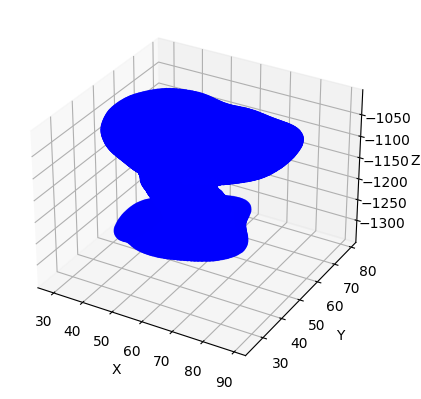

AOI Slice Start:  684
AOI Slice End:  893
AOI Slice Range:  210
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (210, 512, 512)


Number of Paitents:  1
Training Scans Input Shape:  (210, 512, 512)
Training Masks Input Shape:  (210, 512, 512)
Memory usage of training_scans: 210 MB.
Memory usage of train_mask_tibia_labels: 210 MB.


Final Training Image Input Shape:  (210, 512, 512, 1)
Final Training Mask Input Shape:  (210, 512, 512, 1)
------------------------------
Completed Preprocessing Stage!
------------------------------


In [3]:
from preprocessing import preprocessing
import numpy as np
print('-'*30)
print('Loading and preprocessing training data...')
print('-'*30)

# \\files.auckland.ac.nz\research\resmed202100086-tws ----> Address for raw data
total_slices_raw_data = 1015
DataOnlyAOI = True
scans_path = 'D:/MRI - Tairawhiti'
segmasks_fnames = ['1_R_tibia_15A']
scan_data_folders = ['1_AutoBind_WaterWATER_450_15A']

imgs_train, imgs_mask_train = preprocessing(scans_path, segmasks_fnames, scan_data_folders, total_slices_raw_data, DataOnlyAOI)

#TEMP
# imgs_train = imgs_train[70:80]
# imgs_mask_train = imgs_mask_train[70:80]

if (DataOnlyAOI == False):
    imgs_train = np.reshape(imgs_train, (len(scan_data_folders) * total_slices_raw_data, 512, 512))
    imgs_mask_train = np.reshape(imgs_mask_train, (len(segmasks_fnames) * total_slices_raw_data, 512, 512))
    imgs_train = np.expand_dims(imgs_train, axis=-1)
    imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

if (DataOnlyAOI == True):
    imgs_train = np.expand_dims(imgs_train, axis=-1)
    imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

print("\n")
print('Final Training Image Input Shape: ', imgs_train.shape)
print('Final Training Mask Input Shape: ', imgs_mask_train.shape)

print('-'*30)
print('Completed Preprocessing Stage!')
print('-'*30)

In [7]:
import label-studio
from label-studio import LabelStudioApp

LabelStudioApp(port=8080).start()

SyntaxError: invalid syntax (12202413.py, line 1)

Superimposed Mask Visualisation 

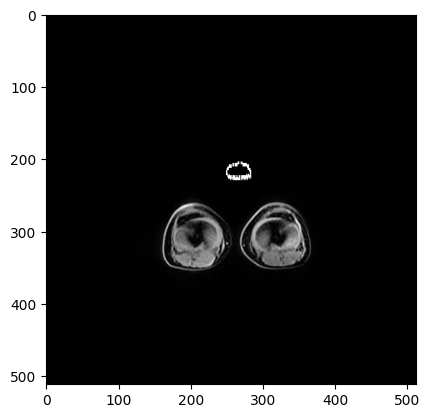

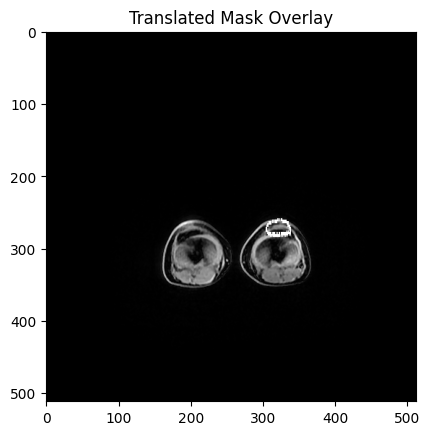

(512, 512, 1)


(-0.5, 511.5, 511.5, -0.5)

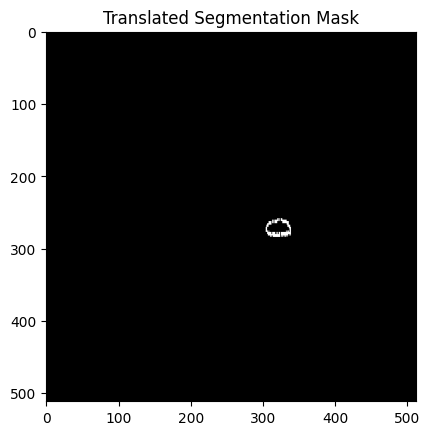

In [4]:
def superimpose_images(image1, image2):
    # Normalize the image intensities to range [0, 1]
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    # Create a new image by overlaying image1 on image2
    alpha = 0.5  # Opacity of image1
    superimposed_image = alpha * image1 + (1 - alpha) * image2

    return superimposed_image

# Load the MRI scans as NumPy arrays
# image1 = np.loadtxt('D:/P4P Model Data/txt/Masks_Tibia/data_200.txt', delimiter=',')
# image2 = np.loadtxt('D:/P4P Model Data/txt/Data_Tibia/data_200.txt', delimiter=',')
image1 = imgs_mask_train[5]
image2 = imgs_train[5]

# Superimpose the images
superimposed_image = superimpose_images(image1, image2)

# Visualize the superimposed image
plt.imshow(superimposed_image, cmap='gray')
plt.axis('on')
plt.show()


def adjust_mask_translation(mask, dicom_image, translation=(0, 0)):
    translated_mask = np.roll(mask, shift=translation, axis=(0, 1))

    # Overlay the translated mask onto the DICOM image for visualization
    overlay = np.where(translated_mask > 0, dicom_image.max(), dicom_image)

    # Plot the DICOM image and the overlay
    if True:
        plt.imshow(overlay, cmap='gray')
        plt.title('Translated Mask Overlay')
        plt.axis('on')
        plt.show()
        print(translated_mask.shape)
        
    return translated_mask


translation = (55, 55)
translated_mask = adjust_mask_translation(image1, image2, translation)
# grayscale_image = np.loadtxt('D:/P4P Model Data/txt/Mask_Tibia(Collab Sample)/data_100.txt', delimiter=',')
fig, ax = plt.subplots()
img = ax.imshow(translated_mask, cmap='gray')
plt.title('Translated Segmentation Mask')
ax.axis('on')

Exporting out Labelled Datasets

In [5]:
# Exporting Training Scan and Mask Data
from writeout_dataset import WriteOutTextFile
from writeout_dataset import WriteOutImagePNGFiles

translation = (55, 55)
for i in range(len(imgs_mask_train)):
    # print(imgs_mask_train[i].shape)
    # print(imgs_train[i].shape)
    imgs_mask_train[i] = adjust_mask_translation(imgs_mask_train[i], imgs_train[i], translation)

starting_slice = 70
save_directory_data_txt = 'D:/P4P Model Data/txt/Data_Tibia(Collab Sample)'
# save_directory_data_img = 'D:/P4P Model Data/img/Data'
save_directory_mask_txt = 'D:/P4P Model Data/txt/Mask_Tibia(Collab Sample)'
# save_directory_mask_img = 'D:/P4P Model Data/img/Masks'

WriteOutTextFile(imgs_train[:, :, :, 0], save_directory_data_txt, starting_slice)   
# # WriteOutImagePNGFiles(imgs_train, save_directory_data_img)

WriteOutTextFile(imgs_mask_train[:, :, :, 0], save_directory_mask_txt, starting_slice)   
# # WriteOutImagePNGFiles(imgs_mask_train, save_directory_mask_img)

Data Validation (Visual Sanity Check)

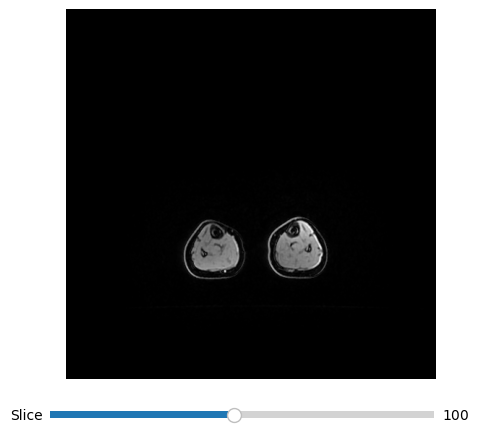

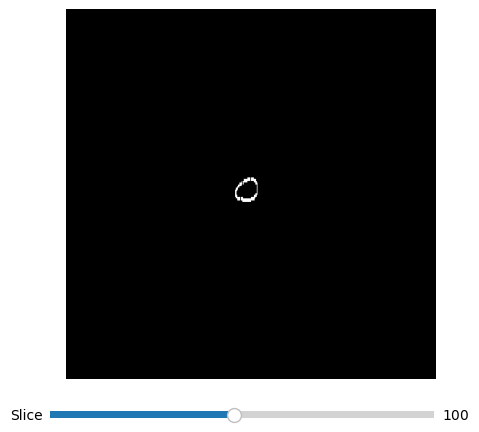

In [8]:
# Visualiser Tool Scan
temp = np.squeeze(imgs_train)
current_slice = 100

fig, ax = plt.subplots()
current_slice = 100
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

# Visualiser Tool Mask
temp = np.squeeze(imgs_mask_train)
fig, ax = plt.subplots()
current_slice = 100
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

2DUNet Model

In [9]:
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Dice Coefficient Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Adding a small constant to avoid division by zero
    print(y_true.shape)
    print(y_pred.shape)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    print(intersection)
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - tf.reduce_mean(dice_coefficient)
    return loss


In [ ]:
from writeout_dataset import ReadInDatasets
imgs_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Data_Tibia (1)', 1, 500)
imgs_mask_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Masks_Tibia (1)', 1, 500)
# imgs_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Data_Tibia(Collab Sample)')
# imgs_mask_train = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Mask_Tibia(Collab Sample)')
# imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)')

imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)
imgs_train = np.expand_dims(imgs_train, axis=-1)

# import backbones_unet
# print(backbones_unet.__available_models__)

print('imgs_train size: ', imgs_train.shape)
print('imgs_mask_train size: ', imgs_mask_train.shape)

In [ ]:
print('-'*30)
print('Training UNet Model...')
print('-'*30)

images_train, images_val, labels_train, labels_val = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=0)
print('Training Image Input Shape: ', images_train.shape)
print('Training Mask Input Shape: ', labels_train.shape)
print('Validation Image Input Shape: ', images_val.shape)
print('Validation Mask Input Shape: ', labels_val.shape)


print('-'*30)
print('Creating and compiling model...')
print('-'*30)

# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
#     tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
# ]

input_shape = (512,512,1)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
# model.compile(optimizer='adam', loss=dice_loss)
checkpoint = ModelCheckpoint('model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5', monitor='val_loss', save_best_only=True, mode='min')
model.fit(x=images_train, y=labels_train, batch_size=4, epochs=20, validation_data=(images_val, labels_val), callbacks=[checkpoint])
model.summary()

Prediction Mask

In [ ]:
model = 'best_model.h5'
# model = 'model(loss=binary,batch_size=4,epochs=20,train_size=500,aoi=tibia).h5'

from writeout_dataset import ReadInDatasets
imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)', 0, 13)
testing_scans_processed = np.reshape(imgs_test, (len(imgs_test), 512, 512, 1))
print('testing_masks_processed size: ', testing_scans_processed.shape)

def superimpose_images(image1, image2):
    # Normalize the image intensities
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    alpha = 0.5  # Opacity of raw scan
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

print('-'*30)
print(f'Prediction Made Using Weights From Model: {model}')
print('-'*30)

pred_img_idx = 3
print('Testing Image Input Shape: ',(np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1))).shape)

best_model = load_model(model)
prediction = best_model.predict(np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1)))
# print('Testing Image Input Shape: ',testing_scans_processed[pred_img_idx].shape)
print('Prediction Mask Shape: ', prediction.shape)
print('\n')

DSC = dice_coefficient((np.reshape(testing_scans_processed[pred_img_idx], (1,512,512,1))), prediction)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

fig, ax = plt.subplots()
ax.imshow(prediction[0, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Segmentation Result')
plt.show()

fig, ax = plt.subplots()
ax.imshow(testing_scans_processed[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Test Scan')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(testing_scans_processed[pred_img_idx, :, :, 0], prediction[0, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Prediction Mask')
plt.show()

Evaluation Metrics

In [88]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

def assd(y_true, y_pred, spacing):
    surface_distances = surface_distance(y_true, y_pred, spacing)
    avg_surface_distance = np.mean(surface_distances)
    return avg_surface_distance

def surface_distance(y_true, y_pred, spacing):
    true_surface = find_surface_points(y_true, spacing)
    pred_surface = find_surface_points(y_pred, spacing)

    if true_surface.shape[0] == 0 or pred_surface.shape[0] == 0:
        raise ValueError("One or both surface point arrays are empty.")

    try:
        surface_distances_true_to_pred = directed_hausdorff(true_surface, pred_surface)[0]
        surface_distances_pred_to_true = directed_hausdorff(pred_surface, true_surface)[0]
        surface_distances = np.concatenate([surface_distances_true_to_pred, surface_distances_pred_to_true])
    except ValueError as e:
        print("Error occurred during Hausdorff distance calculation:", e)
        raise

    return surface_distances

def find_surface_points(mask, spacing):
    mask_padded = np.pad(mask, 1, mode='constant')
    mask_padded_diff = np.diff(mask_padded.astype(int), axis=0)

    surface_points = []
    for z in range(mask_padded_diff.shape[0]):
        surface_indices = np.where(mask_padded_diff[z] != 0)
        if len(surface_indices[0]) > 0:
            surface_points.extend(list(zip(surface_indices[0], surface_indices[1])))

    surface_points = np.array(surface_points)
    surface_points_phys = surface_points * spacing

    return surface_points_phys

def volume_error(y_true, y_pred):
    true_volume = np.sum(y_true)
    pred_volume = np.sum(y_pred)
    volume_error = np.abs(true_volume - pred_volume) / true_volume
    return volume_error

predictions_single_scan_binarized = np.reshape(predictions_single_scan_binarized,(1, 512, 512, 1))
DSC = dice_coefficient(testing_masks_processed, predictions_single_scan_binarized)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# VError = volume_error(testing_masks_processed, prediction)
# print('Volume Error (VError) Metric Value: ', VError)
# print('\n')

# spacing = 1
# ASSD = assd(testing_masks_processed, prediction, spacing)
# print('Average Symmetric Surface Distance (ASSD) Metric Value: ', ASSD)
# print('\n')

Dice Similarity Coefficient (DSC) Metric Value:  [4.0989216e-06]




In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)
    
#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

# # Dice Coefficient Loss Function 
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# # Dice Coefficient Loss Function
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)